# Week 4 - Word Embeddings Supplemental

This notebook contains two additional uses for word embeddings

For this notebook we will be using the following packages

## <span style="color:red">*Exercise 3b*</span>

<span style="color:red">**Do only 3a or 3b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import copy

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [2]:
import os
import re

targetDir = '../data/data/Plato'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Plato = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Plato'})

targetDir = '../data/data/Aristotle'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Aristotle = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Aristotle'})



targetDir = '../data/data/Kant'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Kant = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Kant'})


targetDir = '../data/data/Hegel'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Hegel = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Hegel'})


targetDir = '../data/data/Nietzsche'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

Nietzsche = pandas.DataFrame({'text' : platoText, 'book' : platoFileName, 'author' : 'Nietzsche'})


corpora_df = pandas.concat([Aristotle, Kant, Nietzsche, Hegel, Plato])
corpora_no_remove = pandas.concat([Aristotle, Kant, Nietzsche, Hegel, Plato])

# Remove some features vectors 
remove = np.array(['replied', 'Crito', 'Cleinias', 'Timaeus', 'Protagoras', 'Theaetetus', r'\[\d+\]',
                   'Phaedrus', 'Phaedo', 'SOCRATES', 'Socrates', 'Philebus', 'Parmenides',r'\(\d+\)',
                   'Euthyphro', 'Meno', 'Nicias', 'Polus', 'Cratylus', 'Theodorus', 'Menexenus', 
                   'Nicias', 'Ion', 'Dion', 'Simmias', 'Agathon', 'Hellenes', 'Gorgias', '\n', '\t'
                   'theodorus', 'DIALOGUE', 'Athens', 'Athenian', 'Author', 'Athenians', 'THEODORUS',])
       
for i in range(corpora_df.shape[0]):
    for j in range(len(remove)):
        corpora_df["text"].iloc[i] = re.sub(remove[j], ' ', corpora_df["text"].iloc[i])

In [3]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [4]:
corpora_df['tokenized_sents'] = corpora_df['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
corpora_df['normalized_sents'] = corpora_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic) for s in x])

In [5]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [6]:
rawEmbeddings, comparedEmbeddings = compareModels(corpora_df, 'author')

In [7]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

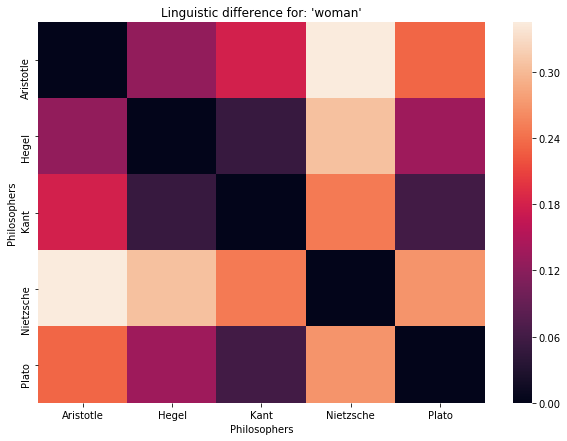

In [9]:
targetWord = 'woman'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_title("Linguistic difference for: '{}'".format(targetWord))
plt.show()

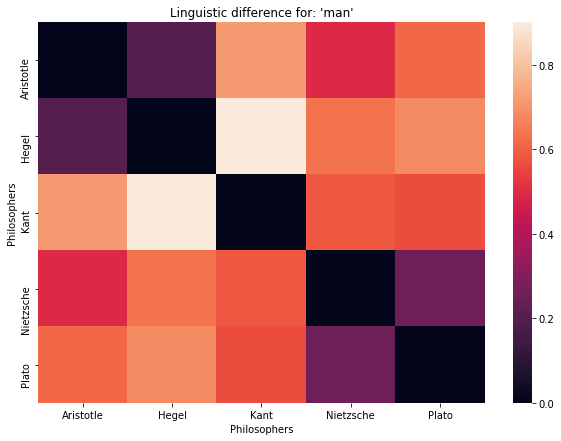

In [20]:
targetWord = 'man'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_title("Linguistic difference for: '{}'".format(targetWord))
plt.show()

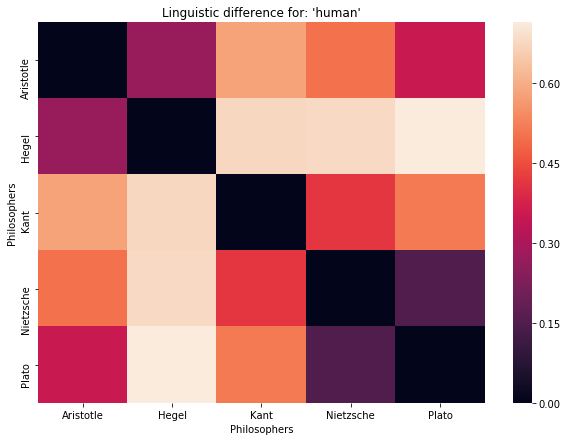

In [8]:
targetWord = 'human'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_title("Linguistic difference for: '{}'".format(targetWord))
plt.show()

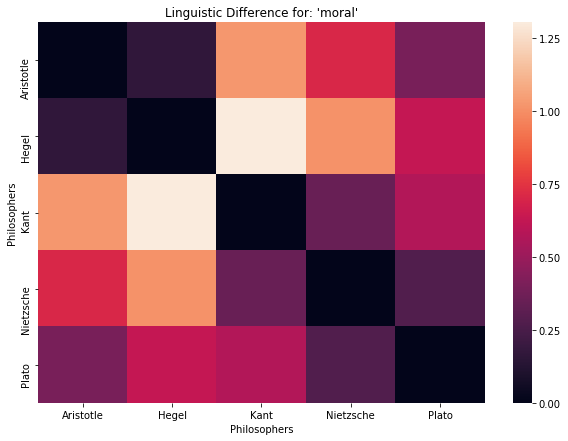

In [10]:
targetWord = 'moral'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_title("Linguistic Difference for: '{}'".format(targetWord))
plt.show()

In [11]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [12]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 3123 words to compare


Most Divergence

In [13]:
wordDivergences[:10]

[('power', 2.9477268531918526),
 ('called', 2.917235404253006),
 ('art', 2.903873724862933),
 ('state', 2.784013882279396),
 ('part', 2.7449143826961517),
 ('said', 2.6258370727300644),
 ('us', 2.618377923965454),
 ('soul', 2.5765960216522217),
 ('let', 2.568046510219574),
 ('many', 2.5511494576931)]

And the least

In [14]:
wordDivergences[-10:]

[('severe', 0.05941438674926758),
 ('secretly', 0.055377185344696045),
 ('newly', 0.05485796928405762),
 ('inflicted', 0.0533866286277771),
 ('entertainment', 0.05240422487258911),
 ('damage', 0.05154848098754883),
 ('rites', 0.05062907934188843),
 ('intent', 0.04793226718902588),
 ('ruined', 0.04740762710571289),
 ('devised', 0.045188307762145996)]

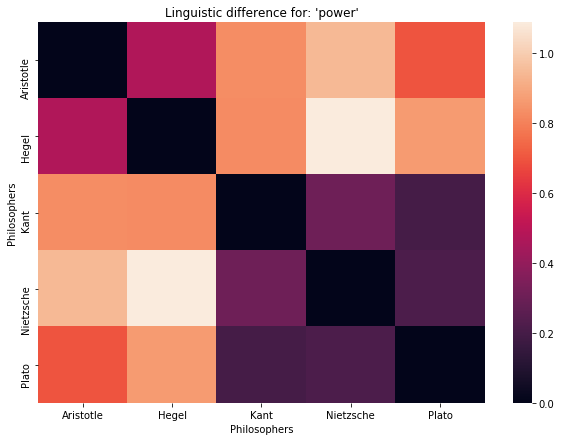

In [15]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_title("Linguistic difference for: '{}'".format(targetWord))
plt.show()

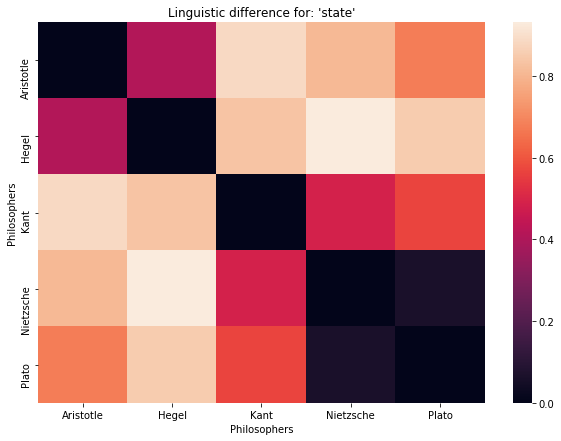

In [22]:
targetWord = wordDivergences[3][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_title("Linguistic difference for: '{}'".format(targetWord))
plt.show()

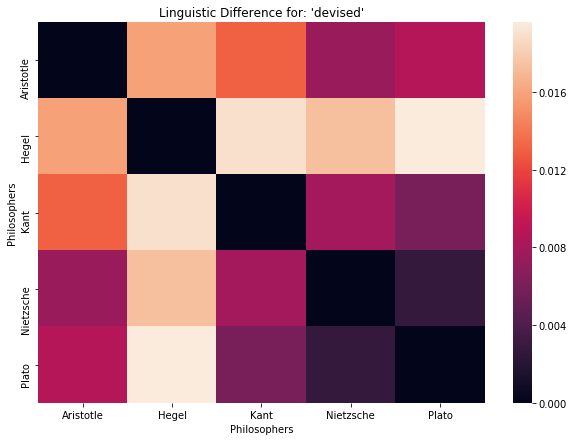

In [17]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_ylabel("Philosophers")
ax.set_title("Linguistic Difference for: '{}'".format(targetWord))
plt.show()

I compared 4 pholosophers' corpora in different eras through word embedding. There are some interesting findings.

First, although these philosophers are from different time periods, their attitudes toward woman are very similar. The highest divergence scores between different philosophers are just around 0.3. However, when we use word "man" and "human", we can find that their meanings in philosophers' books are vastly different. It means that the attitudes toward woman are considerably constant although the attitudes toward human and overall morality have changed a lot.

Second, from all matrices we can find that Plato and Nietzsche share a lot of similarities. This is also true for Aristotle and Hegel (although they are less similar than the forper pair.

Third, when we compare the results of "power" and and "state", it is obvious that overall divergence does not represent that any two philosophers are necessarily different. In terms of "power", Nietzsche, Kant and Plato are very similar but they are vastly different from other people; and in terms of "state", most philosophers are different except for Nietzsche and Plato.

Finally, Plato and Aristotle are in the same time period, but they don't have many similarities according to the words we present here.
